<a href="https://colab.research.google.com/github/KevinTheRainmaker/AI-ML_Team_5/blob/main/KangbeenKo/Kaggle02_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Novice to Grandmaster
### Competition #2: Natural Language Processing with Disaster Tweets

- https://www.kaggle.com/c/nlp-getting-started

[설명]

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/data/Kaggle'

Mounted at /content/drive


In [65]:
# Packages

# Pyhton's Basic packages
import os

import pandas as pd
import numpy as np
import math, re, time, random, string

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# for NLP
from collections import defaultdict
import wordcloud

# install nltk
!pip install -U -q nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

# to see progress
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

# No Warnings
import warnings
warnings.filterwarnings(action='ignore')

# Kaggle API Set-up
!pip install -q --upgrade --force-reinstall --no-deps kaggle
os.environ['KAGGLE_USERNAME'] = 'kangbeenko'
os.environ['KAGGLE_KEY'] = '7bf5875a0067e432fb8a9300acd60b8e'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



0it [00:00, ?it/s]
0it [1:32:38, ?it/s]


## Dataset

In [3]:
!kaggle competitions download -c nlp-getting-started
!mv nlp-getting-started.zip drive/MyDrive/data/Kaggle/

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 78.7MB/s]


In [4]:
!unzip drive/MyDrive/data/Kaggle/nlp-getting-started.zip

Archive:  drive/MyDrive/data/Kaggle/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
!unzip drive/MyDrive/data/Kaggle/glove.twitter.27B.zip

Archive:  drive/MyDrive/data/Kaggle/glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [6]:
train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

print("Trainset counts: ", train_df['id'].count())
print("Testset counts: ", test_df['id'].count())

Trainset counts:  7613
Testset counts:  3263


In [7]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [8]:
test_df.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


target이 1이면 disaster tweet이고, 0인 경우 disaster tweet이 아니다.

In [9]:
print(train_df[train_df["target"] == 0]["text"].values[1])
print(train_df[train_df["target"] == 1]["text"].values[1])

I love fruits
Forest fire near La Ronge Sask. Canada


In [10]:
print(train_df[train_df["keyword"].notnull()].iloc[0])

id                                                         48
keyword                                                ablaze
location                                           Birmingham
text        @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                      1
Name: 31, dtype: object


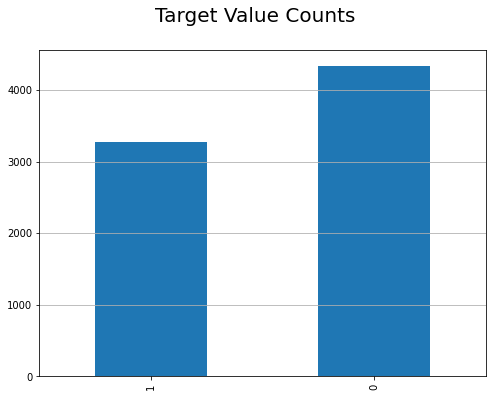

In [11]:
# Plotting target value counts
plt.figure(figsize=(8,6))
ax = train_df['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

In [12]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

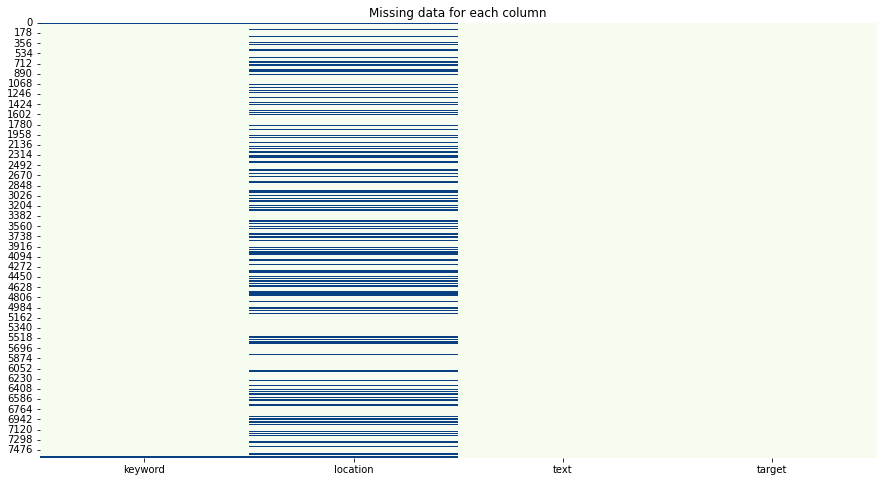

In [13]:
plt.figure(figsize=(15,8))
sns.heatmap(train_df.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

In [14]:
lengths = np.array([len(x) for x in train_df['text']])
print(np.mean(lengths), np.median(lengths))

101.03743596479706 107.0


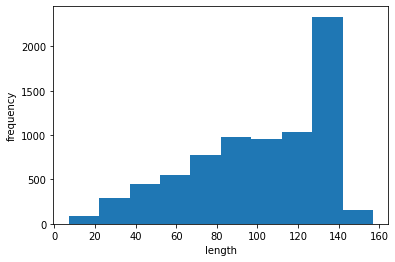

In [15]:
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

## Cleaning

In [67]:
train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

In [36]:
# #remove punctuation
# def remove_punctuation(x):
#     return str(x).translate(str(x).maketrans('', '', "!$%&()*+,-./:;<=>?[\]^_`{|}~"))

# #replace # to tag, @ to mention
# def replace_special_puctuation(x):
#   return str(x).replace('#', 'tag:').replace('@', 'mention:')

# #remove stopwords
# def remove_stopwords(x):
#     return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

# #remove words with non-alphabet characters
# def remove_non_alphabet(x):
#     return ' '.join([i for i in x.split() if i.isalpha()])

# def strip_all_entities(x):
#     return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [81]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def clean_text(x):
    # remove URL from text
    x_no_url = re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.IGNORECASE|re.MULTILINE)
    
    # remove numbers from text
    x_no_num = re.sub(r'\d+', '', x_no_url)

    # remove shortwords from text
    x_no_short = re.sub(r'\W*\b\w{1,2}\b', '', x_no_num)

    # tokenize each text
    word_tokens = word_tokenize(x_no_short)
    
    # remove spatial character
    clean_text = []
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))

    # remove stop words and lower
    x_with_no_stop_word = [w.lower() for w in clean_text if not w in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in x_with_no_stop_word]

    # do lemmatization
    lemmatized_text = [lemmatizer.lemmatize(w, 'v') for w in stemmed_text]
    
    return " ".join(" ".join(lemmatized_text).split())

In [82]:
# create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

# showcase spellcheck 
mispelled = 'Pleaze spel check this sentince'
spell_check(mispelled)

'Please spell check this sentence'

In [83]:
# # decontract contractions
# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won\'t", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"'re", " are", phrase)
#     phrase = re.sub(r"'s", " is", phrase)
#     phrase = re.sub(r"'d", " would", phrase)
#     phrase = re.sub(r"'ll", " will", phrase)
#     phrase = re.sub(r"'t", " not", phrase)
#     phrase = re.sub(r"'ve", " have", phrase)
#     phrase = re.sub(r"'m", " am", phrase)
#     return phrase

decontraction: https://gist.github.com/nealrs/96342d8231b75cf4bb82

In [97]:
total = [train_df, test_df]
for dataset in total:
    #apply all of above functions
    # dataset['text'] = dataset['text'].progress_apply(spell_check)
    dataset['keyword'].fillna('none', inplace=True)
    # dataset['keyword'] = dataset['keyword'].progress_apply(spell_check)
    dataset['clean_text'] = dataset['text'].progress_apply(clean_text)
    dataset['clean_keyword'] = dataset['keyword'].apply(clean_text)
    dataset['keyword_text'] = dataset['clean_keyword'] + " " + dataset["clean_text"]

100%|██████████| 3263/3263 [00:01<00:00, 2109.59it/s]


In [98]:
train_df[:5]

,id,keyword,location,text,target,clean_text,clean_keyword,keyword_text
0,1,none,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquak may allah forgiv,none,none our deed reason earthquak may allah forgiv
1,4,none,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada,none,none forest fire near rong sask canada
2,5,none,NaN,All residents asked to 'shelter in place' are ...,1,all resid ask shelter place notifi offic evacu...,none,none all resid ask shelter place notifi offic ...
3,6,none,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california,none,none peopl receiv wildfir evacu order california
4,7,none,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just get send photo rubi alaska smoke wildfir ...,none,none just get send photo rubi alaska smoke wil...


In [99]:
tweets = [tweet for tweet in train_df['keyword_text']]

In [100]:
tweets[:5]

['none our deed reason earthquak may allah forgiv',
 'none forest fire near rong sask canada',
 'none all resid ask shelter place notifi offic evacu shelter place order expect',
 'none peopl receiv wildfir evacu order california',
 'none just get send photo rubi alaska smoke wildfir pour school']

## Tokenizing

In [101]:
from keras.preprocessing.text import Tokenizer

#define tokenizer options
tokenizer = Tokenizer(oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index
print(word_index)
print('Found %s unique tokens.' % len(word_index))

{'<OOV>': 1, 'the': 2, 'fire': 3, 'get': 4, 'like': 5, 'bomb': 6, 'amp': 7, 'burn': 8, 'emerg': 9, 'flood': 10, 'build': 11, 'disast': 12, 'fatal': 13, 'bodi': 14, 'evacu': 15, 'crash': 16, 'storm': 17, 'new': 18, 'attack': 19, 'bag': 20, 'derail': 21, 'scream': 22, 'collaps': 23, 'suicid': 24, 'via': 25, 'wind': 26, 'one': 27, 'drown': 28, 'peopl': 29, 'say': 30, 'news': 31, 'hijack': 32, 'death': 33, 'obliter': 34, 'polic': 35, 'time': 36, 'kill': 37, 'wreck': 38, 'video': 39, 'make': 40, 'nuclear': 41, 'accid': 42, 'destroy': 43, 'weapon': 44, 'sink': 45, 'deton': 46, 'come': 47, 'injuri': 48, 'murder': 49, 'surviv': 50, 'see': 51, 'year': 52, 'go': 53, 'explod': 54, 'collid': 55, 'blow': 56, 'riot': 57, 'look': 58, 'hazard': 59, 'day': 60, 'you': 61, 'think': 62, 'take': 63, 'home': 64, 'hostag': 65, 'quarantin': 66, 'mass': 67, 'rescu': 68, 'crush': 69, 'catastroph': 70, 'dead': 71, 'know': 72, 'first': 73, 'would': 74, 'love': 75, 'famili': 76, 'delug': 77, 'this': 78, 'fear': 79

In [102]:
sequences = tokenizer.texts_to_sequences(tweets)
print(sequences)

[[218, 570, 3524, 494, 123, 131, 1323, 2793], [218, 97, 3, 182, 5051, 5052, 1034], [218, 237, 1324, 554, 1777, 444, 5053, 334, 15, 1777, 444, 414, 469], [218, 29, 2345, 100, 15, 414, 92], [218, 297, 4, 327, 238, 3525, 1591, 132, 100, 2346, 226], [218, 2347, 308, 92, 1325, 423, 756, 495, 877, 415, 3, 3526, 100], [218, 10, 12, 721, 289, 111, 696, 10, 488, 5054, 878, 791, 342], [218, 293, 1094, 51, 3, 1778], [218, 248, 9, 15, 298, 11, 722, 488], [218, 2017, 201, 47, 342], [218, 522, 29, 156, 157, 106, 542], [218, 723, 523, 2348, 4, 10, 2794, 408, 445, 101, 523, 2348, 118, 356, 167, 118, 356, 167, 5055, 10], [218, 289, 10, 1326, 5056, 2348, 60, 375, 2795], [218, 10, 3527, 757, 758, 3527], [218, 102, 226, 424, 3528, 103, 16, 151], [218, 118, 105], [218, 75, 1446], [218, 376, 75], [218, 103, 639], [218, 118, 5057], [218, 2018], [218, 879, 470], [218, 75, 3529], [218, 118, 524, 60], [218, 5058], [218, 135, 936, 299], [218, 108, 1095, 136, 382], [218, 75, 1779], [218, 5059], [218, 5, 3530], [2

In [103]:
from keras.preprocessing.sequence import pad_sequences

data = pad_sequences(sequences)
label = train_df['target']
print(data.shape)
print(label.shape)

(7613, 23)
(7613,)


In [104]:
MAX_SEQUENCE_LENGTH = data.shape[1]
print(MAX_SEQUENCE_LENGTH)

23


## Word Embedding

### GloVe
Word2Vec과 LSA의 단점을 해소한 임베딩 방법론

In [105]:
path_to_glove_file = './glove.twitter.27B.200d.txt'

In [106]:
# Read word embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("\nFound %s word vectors." % len(embeddings_index))

1193514it [00:47, 24939.46it/s]


Found 1193514 word vectors.


In [ ]:
EMBEDDING_DIM = 200
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 16108/16108 [00:00<00:00, 381504.91it/s]

Our embedded matrix is of dimension (16109, 200)


In [ ]:
from sklearn.model_selection import train_test_split
# split train and validation
X_train, X_val, y_train, y_val = train_test_split(train_df.iloc[:,:4],
                                                  train_df['target'],
                                                  test_size=0.2,
                                                  random_state=0, 
                                                  shuffle=True)

In [ ]:
X_train[:5]

,id,keyword,location,text
1386,1999,bush%20fires,NaN,ted cruz fires back jeb amp bush lose republic...
4048,5751,forest%20fires,NaN,first year forest service spent half annual bu...
3086,4428,electrocute,NaN,lightseraphs pissed pikachu electrocute
272,396,apocalypse,ColoRADo,im gonna fight taylor soon
7462,10678,wounds,"Tampa, FL",sure covering head wounds scabs solution


In [ ]:
y_train[:5]

1386    0
4048    1
3086    0
272     0
7462    0
Name: target, dtype: int64

### LSTM

In [ ]:
# Define some hyperparameters
embedding_dim = 300
learning_rate = 1e-4
batch_size = 1024
epochs = 100
sequence_len = 100

In [ ]:
# # Define train and test labels
# y_train_LSTM = y_train.values.reshape(-1,1)
# y_val_LSTM = y_val.values.reshape(-1,1)

# print("Training Y shape:", y_train_LSTM.shape)
# print("Testing Y shape:", y_val_LSTM.shape)

In [ ]:
# Tokenize train data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  14044


In [ ]:
test_tweets = [ttweets for ttweets in test_df['text']]

In [ ]:
# Pad train and test 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_tweets), maxlen=sequence_len)
print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_val.shape)

Training X shape:  (6090, 100)
Testing X shape:  (1523, 100)


Found 400000 word vectors.


In [ ]:
import tensorflow as tf

# Define embedding layer in Keras
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

In [ ]:
# Define model architecture
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same')(embedding_sequences)
x = tf.keras.layers.MaxPool1D(2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          4213200   
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 128)          192128    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 128)          0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 512)               131584

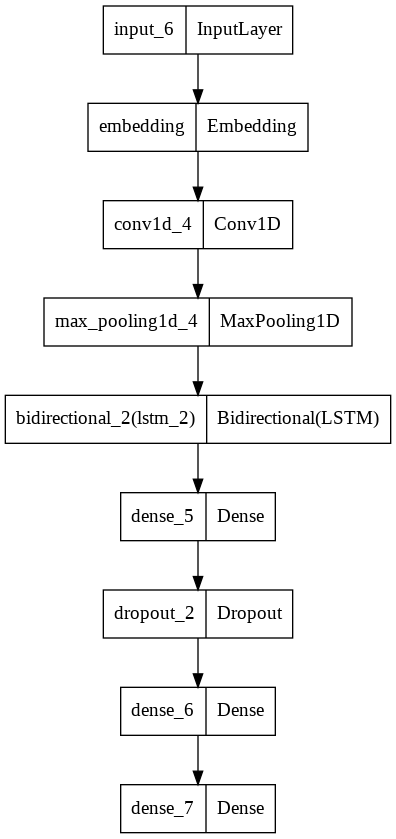

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Optimize the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [ ]:
X_train

array([[    0,     0,     0, ...,  1270,     1,    14],
       [    0,     0,     0, ...,  1066,    33,  3530],
       [    0,     0,     0, ...,  3531,  5329,   464],
       ...,
       [    0,     0,     0, ...,   340,  4221, 14041],
       [    0,     0,     0, ...,  1429,  1290,   242],
       [    0,     0,     0, ...,  2242,   197,   227]], dtype=int32)

In [ ]:
# Train the LSTM Model
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

ValueError: ignored

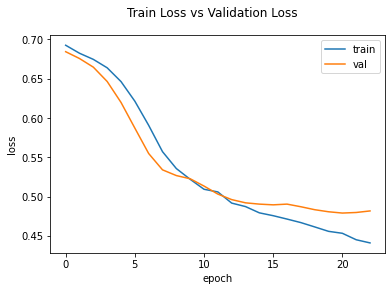

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.suptitle("Train Loss vs Validation Loss")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model = tf.keras.models.load_model('best-lstm-model.h5')

In [ ]:
sample_submission = pd.read_csv("./sample_submission.csv")
predictions = model.predict(X_test)
threshold = 0.5
sample_submission["target"] = (predictions[:,0] > threshold).astype(np.int)

In [ ]:
sample_submission.to_csv('./submission.csv', index=False)
sample_submission

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "threshold 0.5"

100% 22.2k/22.2k [00:01<00:00, 12.6kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets